# Oracles and the Deutsch-Jozsa algorithm

### Package Installation

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ, execute
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit_textbook.problems import dj_problem_oracle

Many quantum algoritms revolve around the notion of so called $\textit{oracles}$. An oracle is a function that can be considered as a 'black box'. We generally want to find out specific properties of this function. We do this by asking questions to the oracle (*querying*). The query complexity is then defined as the minimum number of queries in order to find these properties.


To get familiar with the use of oracles we will now consider the Deutsch-Josza problem. We will see that the quantum solution has a drastically lower query complexity than its classical counterpart.


## II.1: Deutsch-Jozsa Problem <a id='djproblem'> </a>

We are given a hidden Boolean function $f$, which takes as input a string of bits, and returns either $0$ or $1$, that is:

$$
f(\{x_0,x_1,x_2,...\}) \rightarrow 0 \textrm{ or } 1 \textrm{ , where } x_n \textrm{ is } 0 \textrm{ or } 1$$

The property of the given Boolean function is that it is guaranteed to either be balanced or constant. A constant function returns all $0$'s or all $1$'s for any input, while a balanced function returns $0$'s for exactly half of all inputs and $1$'s for the other half. Our task is to determine whether the given function is balanced or constant.

The Deutsch-Jozsa algorithm was the first example of a quantum algorithm that performs better than the best classical algorithm. It showed that there can be advantages to using a quantum computer as a computational tool for a specific problem.


In the Deutsch-Josza problem you are given an unknown orcale. This is in Qiskit implemented by the function:

In [2]:
oraclenr = 4 # determines the oracle (can range from 1 to 5)
oracle = dj_problem_oracle(oraclenr) # gives one out of 5 oracles
oracle.name = "DJ-Oracle"

This function gives a certain oracle with 5 input qubits. The last qubit ($q_4$) will be the output. In order to get a feeling for the oracle, let us create a circuit to which we add the oracle such that we can pass it different input strings and then measure the output of $q_4$. This corresponds to the classical way of determining whether the oracle is balanced or constant.

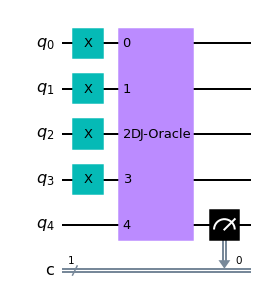

In [3]:
def dj_classical(n, input_str):
    
    # build a quantum circuit with n qubits and 1 classical readout bit
    dj_circuit = QuantumCircuit(n+1,1)
    
    # Prepare the initial state corresponding to your input bit string
    for i in range(n):
        if input_str[i] == '1':
            dj_circuit.x(i)
    
    # append oracle
    dj_circuit.append(oracle, range(n+1))
    
    # measure the fourth qubit 
    dj_circuit.measure(n,0)
    
    return dj_circuit
    
n = 4 # number of qubits
input_str = '1111'
dj_circuit = dj_classical(n, input_str)
dj_circuit.draw("mpl") # draw the circuit

Now we simulate the results to find the outcome of this circuit. Try different input bit strings to see the corresponding outputs!

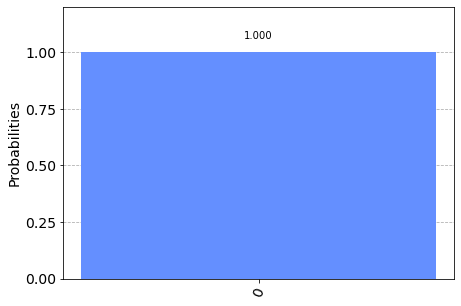

In [4]:
input_str = '0000'
dj_circuit = dj_classical(n, input_str)
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_dj_circuit = transpile(dj_circuit, qasm_sim)
qobj = assemble(transpiled_dj_circuit, qasm_sim)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

Do you already have an idea whether the oracle is balanced or constant? What is the minimum and maximum number of inputs you would need to check to know whether this 4 bit classical Deutsch-Josza oracle is balanced or constant?

Answer: The oracle is balanced because for half of the inputs it's giving us an output 1 and for the other half of the input it's giving us an output 0. The minimum 

In [5]:
def classical():
    min_nr_inputs = 2
    max_nr_inputs = 9
    return [min_nr_inputs, max_nr_inputs]

In [6]:
classical()

[2, 9]

## II.2: Quantum Solution to the Deutsch-Josza Problem

Using a quantum computer, we can find out if the oracle is constant or balanced with 100% confidence after only one call to the function $f(x)$, provided we have the function $f$ implemented as a quantum oracle, which maps the state $\vert x\rangle \vert y\rangle $ to $ \vert x\rangle \vert y \oplus f(x)\rangle$, where $\oplus$ is addition modulo $2$. Below we will walk through the algorithm.

Prepare two quantum registers. The first is an $n$-qubit register initialised to $|0\rangle$, and the second is a one-qubit register initialised to $|-\rangle =\frac{1}{\sqrt{2}}\left(|0\rangle - |1 \rangle \right)$. Note, that with Qiskit states are described as $\vert b_3 b_2 b_1 b_0\rangle_{q_3q_2q_1q_0}$, i.e. just like for binary numbers, the last bit $b_0$ corresponds to the state of the first qubit. Thus, we want to initialize the state $$\vert \psi_0 \rangle = \vert -\rangle \otimes \vert0\rangle^{\otimes n}.$$

In [7]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

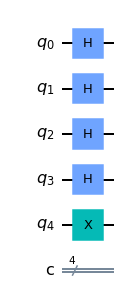

In [8]:
n=4
def psi_0(n):
    qc = QuantumCircuit(n+1,n)
    
    # Build the state (|00000> - |10000>)/sqrt(2)
    #
    # FILL YOUR CODE IN HERE
    #
    qc.x(n)
    for i in range(n):
        qc.h(i)
    
    return qc

dj_circuit = psi_0(n)
dj_circuit.draw("mpl")

Applying the quantum bit oracle to any state $\vert x\rangle \vert y\rangle$ would yield the state $\vert x\rangle \vert y \oplus f(x)\rangle$.
As we have prepared the state $|y\rangle$, which corresponds to the state on the last qubit $q_n$, in the state $|-\rangle$, the output of the oracle for any input bitstring $x$ is given by:
$$ \frac{1}{\sqrt{2}}\vert x\rangle (\vert f(x)\rangle - \vert 1 \oplus f(x)\rangle) = \frac{1}{\sqrt{2}} (-1)^{f(x)}|x\rangle (|0\rangle - |1\rangle ) = (-1)^{f(x)}|x\rangle |-\rangle.$$
Thus, we have created a phase oracle acting on the bit string $x$.

Before applying the oracle, we need to create our input state on the first $n$ qubits though. For that we want an equal superposition state, so that the total state on all $n+1$ qubits is given by $$\vert \psi_1 \rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle \left(|0\rangle - |1 \rangle \right)$$ 

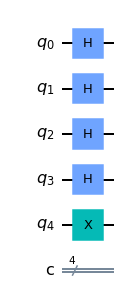

In [9]:
def psi_1(n):
    
    # obtain the |psi_0> = (|00000> - |10000>)/sqrt(2) state
    qc = psi_0(n)
    
    # create the superposition state |psi_1>
    #
    #
    # FILL YOUR CODE IN HERE
    #

    return qc

dj_circuit = psi_1(n)
dj_circuit.draw("mpl")

Now we are ready to apply our oracle to the prepared superposition state $\vert \psi_1 \rangle$. This gives the state
$$ \vert \psi_2 \rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle (\vert f(x)\rangle - \vert 1 \oplus f(x)\rangle) = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}|x\rangle (|0\rangle - |1\rangle ) = \frac{1}{\sqrt{2^{n}}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}|x\rangle |-\rangle.$$

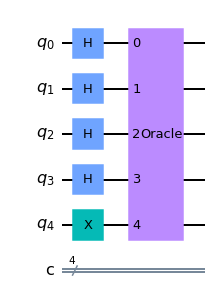

In [10]:
def psi_2(case,n):
    
    # circuit to obtain psi_1
    qc = psi_1(n)
    
    # append the oracle
    oracle = dj_oracle(case, n)
    qc.append(oracle, range(n+1))
    
    return qc

dj_circuit = psi_2("balanced", n)
dj_circuit.draw("mpl")

In the final part of our algorithm we disregard the outcome on our second register and we apply an n-fold Hadamard to our first register. Afterwards we measure the outcome on these qubits.

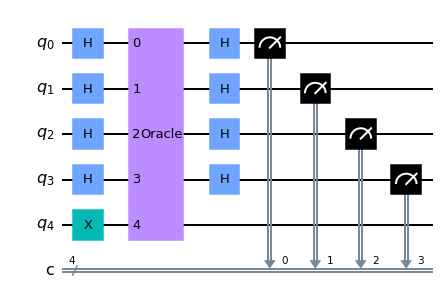

In [11]:
def dj_algorithm(case, n): # note that this exercise also depends on the code in the functions psi_0 (In [24]) and psi_1 (In [25])
    qc = psi_2(case, n)
    
    # apply n-fold hadamard gate
    #
    #
    # FILL YOUR CODE IN HERE
    
    for i in range(n):
        qc.h(i)
    #
       
    # add the measurement by connecting qubits to classical bits
    #
    #
    # FILL YOUR CODE IN HERE
    for i in range(n):
        qc.measure(i, i)
    #
    
    return qc
dj_circuit = dj_algorithm("balanced", n)
dj_circuit.draw("mpl")

At this point the second single qubit register may be ignored. Applying a Hadamard gate to each qubit in the first register yields the state:
        $$
        \begin{aligned}
            \lvert \psi_3 \rangle 
                & = \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)}
                    \left[ \sum_{y=0}^{2^n-1}(-1)^{x \cdot y} 
                    \vert y \rangle \right] \\
                & = \frac{1}{2^n}\sum_{y=0}^{2^n-1}
                    \left[ \sum_{x=0}^{2^n-1}(-1)^{f(x)+x \cdot y} \right]
                    \vert y \rangle,
        \end{aligned}
        $$
       
where $x \cdot y = x_0y_0 \oplus x_1y_1 \oplus \ldots \oplus x_{n-1}y_{n-1}$ is the sum of the bitwise product.

Let us now run the circuit including the measurement of the first register on the simulator:

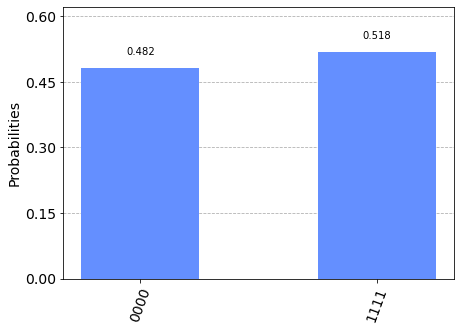

In [12]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_dj_circuit = transpile(dj_circuit, qasm_sim)
qobj = assemble(transpiled_dj_circuit)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

### Challenge Question

Transform the functions highlighted in section above to create new funtions that take in a string of binary values such as "11111" and applies a constant/balanced oracle to this input. Then, provides an output for the result. Test this oracle with the input “10010” for both the balanced and constant oracles to see its outcome. Print out the results of your experiment on histograms to see whether it works or not. For this function to work you will have to revise the psi_0(n), psi_1(n), psi_2(case, n) functions as well as the dj_algorithm(case, n) functions. After inputing the string, the length of the string will be used to calculate both the number of qubits in the first register and the number of classical bits in the second register that will go into creating the quantum circuit. The templates for the revised functions have been provided.

**Note: Qiskit reads binary values from left to right so 10010 would be 01001 on Qiskit. You can reverse the order of your input string by running this code `string = string[::1]` in the psi_0 function**

In [65]:
string = "abc"
len(string[::-1])

3

In [91]:
def psi_0(string):
    string = string[::-1]
    n = len(string)
    qc = QuantumCircuit(n + 1,n)
    
    for i in range(n):
        if string[i] == "1":
            qc.x(i)
        else:
            qc.i(i)
    
    # Build the state 
    #
    # FILL YOUR CODE IN HERE
    #
    qc.x(n)
    for i in range(n+1):
        qc.h(i)
    
    return qc

In [92]:
def psi_1(string):
    
    # obtain the |psi_0>
    qc = psi_0(string)
    
    # create the superposition state |psi_1>
    #
    #
    # FILL YOUR CODE IN HERE
    #
    
    return qc

In [93]:
def psi_2(string, case):
    
    # circuit to obtain psi_1
    qc = psi_0(string)
    
    # append the oracle
    oracle = dj_oracle(case, len(string))
    qc.append(oracle, range(len(string)+1))
    
    return qc

In [94]:
def dj_algorithm(string, case): 
    qc = psi_2(string, case)
    
    # apply n-fold hadamard gate
    #
    #
    # FILL YOUR CODE IN HERE
    #
    for i in range(len(string)):
        qc.h(i)
    #
       
    # add the measurement by connecting qubits to classical b
        
    for i in range(len(string)):
        qc.measure(i, i)
    return qc

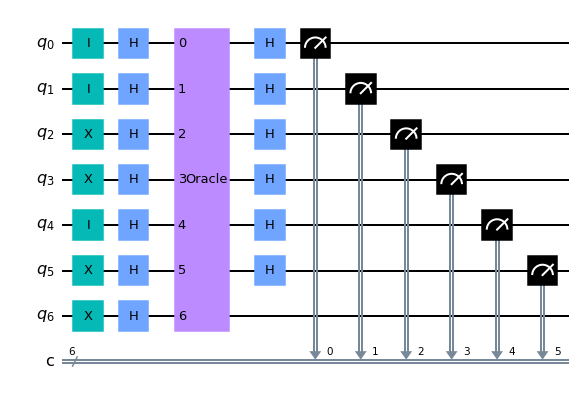

In [95]:
qc = QuantumCircuit()
dj_qc = dj_algorithm("101100","balanced")
dj_qc.draw("mpl")

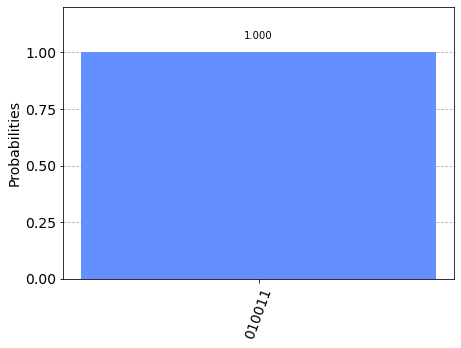

In [96]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_dj_circuit = transpile(dj_qc, qasm_sim)
qobj = assemble(transpiled_dj_circuit)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)